In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm

from scipy.stats import chi2_contingency

# Prepare data #

## Load data ##

In [2]:
df = pd.read_csv('rgr_data_test (1).csv')

# Fill the empty referalls to 0
df.REFERRALS_CUMULATIVE = df.REFERRALS_CUMULATIVE.fillna(0)
df.SUCCESSFUL_REFERRALS_CUMULATIVE = df.SUCCESSFUL_REFERRALS_CUMULATIVE.fillna(0)

# Convert columns to datetime's
df.APPLICATION_DATE = pd.to_datetime(df.APPLICATION_DATE)
df.APPLICATION_APPROVED_DATE = pd.to_datetime(df.APPLICATION_APPROVED_DATE)
df.FIRST_WORK_DATE = pd.to_datetime(df.FIRST_WORK_DATE)

days = df.DAYS_SINCE_ACQUISITION.unique()

df

,RIDER_ID,LOCATION,APPLICATION_DATE,APPLICATION_APPROVED_DATE,FIRST_WORK_DATE,ACQUISITION_CHANNEL,VEHICLE_TYPE,DAYS_SINCE_ACQUISITION,HOURS_WORKED_CUMULATIVE,ORDERS_DELIVERED_CUMULATIVE,THROUGHPUT_CUMULATIVE,REFERRALS_CUMULATIVE,SUCCESSFUL_REFERRALS_CUMULATIVE
0,73350,Roo de Janeiro,2016-10-29,2016-11-07,2016-11-09,Organic,Bicycle,7,11.9,12,1.01,0.0,0.0
1,73350,Roo de Janeiro,2016-10-29,2016-11-07,2016-11-09,Organic,Bicycle,14,13.1,13,0.99,0.0,0.0
2,73350,Roo de Janeiro,2016-10-29,2016-11-07,2016-11-09,Organic,Bicycle,28,19.1,20,1.04,0.0,0.0
3,73350,Roo de Janeiro,2016-10-29,2016-11-07,2016-11-09,Organic,Bicycle,56,33.4,39,1.17,0.0,0.0
4,73350,Roo de Janeiro,2016-10-29,2016-11-07,2016-11-09,Organic,Bicycle,84,33.4,39,1.17,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31033,101217,Roo York,2017-02-27,2017-03-18,2017-03-18,Digital,Scooter / Motorcycle,14,29.6,61,2.06,0.0,0.0
31034,101217,Roo York,2017-02-27,2017-03-18,2017-03-18,Digital,Scooter / Motorcycle,28,55.5,123,2.22,0.0,0.0
31035,101217,Roo York,2017-02-27,2017-03-18,2017-03-18,Digital,Scooter / Motorcycle,56,62.8,138,2.20,0.0,0.0
31036,101217,Roo York,2017-02-27,2017-03-18,2017-03-18,Digital,Scooter / Motorcycle,84,67.1,145,2.16,0.0,0.0


## Adding some extra stats ##
We only really care about Referrals vs Not. Hence we make a convenience `IS_RGR` column for that.

In [3]:
df['IS_RGR'] = (df.ACQUISITION_CHANNEL == 'Referral')

We also add a `CHURNED_AFTER` column which incdicates the last time they posted new hours

In [4]:
max_hrs = df.groupby('RIDER_ID').HOURS_WORKED_CUMULATIVE.transform(max)
df['CHURNED_AFTER'] = df[df.HOURS_WORKED_CUMULATIVE >= max_hrs].groupby('RIDER_ID').DAYS_SINCE_ACQUISITION.transform(min)
df.CHURNED_AFTER = df.groupby('RIDER_ID').CHURNED_AFTER.transform(lambda x: np.nan if x.mean() == max(days) else x.fillna(x.mean()))
del max_hrs

It's also a bit easier to work with a rolled up version of the dataframe:

Before doing that, we should double check that that everything within a `RIDER_ID` group matches.

In [5]:
index = ['RIDER_ID', 'LOCATION', 'APPLICATION_DATE', 'APPLICATION_APPROVED_DATE', "FIRST_WORK_DATE", 'IS_RGR', 'CHURNED_AFTER', 'ACQUISITION_CHANNEL', 'VEHICLE_TYPE']
for col in index:  # tqdm.tqdm(index):
    assert not np.logical_and(df.groupby('RIDER_ID').APPLICATION_DATE.transform(lambda x: np.mean(x)) != df.APPLICATION_DATE, ~df.APPLICATION_DATE.isna()).any()
    
df[np.logical_and(df.groupby('RIDER_ID').APPLICATION_DATE.transform(lambda x: np.mean(x)) != df.APPLICATION_DATE, ~df.APPLICATION_DATE.isna())]

df_rolled = df.pivot(index=index, columns=['DAYS_SINCE_ACQUISITION']).reset_index()
df_rolled.columns = pd.Index([f"{e[0]}_{e[1]}" if e[1] else e[0] for e in df_rolled.columns.tolist()])
df_rolled["CHURNED"] = (~df_rolled.CHURNED_AFTER.isna()).astype(int)

assert (np.sort(df_rolled.RIDER_ID.unique()) == np.sort(df.RIDER_ID.unique())).all()
assert len(df.RIDER_ID.unique()) == len(df) / len(days) == len(df_rolled)
del index
# del df
df_rolled

,RIDER_ID,LOCATION,APPLICATION_DATE,APPLICATION_APPROVED_DATE,FIRST_WORK_DATE,IS_RGR,CHURNED_AFTER,ACQUISITION_CHANNEL,VEHICLE_TYPE,HOURS_WORKED_CUMULATIVE_7,...,REFERRALS_CUMULATIVE_56,REFERRALS_CUMULATIVE_84,REFERRALS_CUMULATIVE_168,SUCCESSFUL_REFERRALS_CUMULATIVE_7,SUCCESSFUL_REFERRALS_CUMULATIVE_14,SUCCESSFUL_REFERRALS_CUMULATIVE_28,SUCCESSFUL_REFERRALS_CUMULATIVE_56,SUCCESSFUL_REFERRALS_CUMULATIVE_84,SUCCESSFUL_REFERRALS_CUMULATIVE_168,CHURNED
0,1864,Roo York,2017-03-05,2017-03-31,2017-04-03,False,NaN,Digital,Scooter / Motorcycle,41.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0
1,3062,Roo York,2015-06-09,2016-10-22,2016-10-30,False,7.0,Offline,Bicycle,15.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,5276,Roo York,2015-07-31,2015-08-07,2017-04-01,False,28.0,Organic,Scooter / Motorcycle,7.4,...,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,9510,Roo York,2015-09-29,2016-10-22,2016-10-28,False,NaN,Digital,Bicycle,28.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,16977,Roo York,2015-10-30,2016-02-04,2017-03-24,False,56.0,Organic,Bicycle,9.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5168,103762,Roo York,2017-03-31,2017-04-07,2017-04-08,False,NaN,Offline,Scooter / Motorcycle,39.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5169,103764,Roo York,2016-09-24,2017-04-07,2017-04-07,True,NaN,Referral,Scooter / Motorcycle,38.1,...,1.0,4.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,0
5170,103774,Roo York,2017-02-26,2017-04-07,2017-04-07,False,NaN,Organic,Scooter / Motorcycle,27.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5171,103775,Roo York,2016-03-17,2017-04-07,2017-04-07,True,NaN,Referral,Scooter / Motorcycle,20.2,...,4.0,4.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,0


We will see laters that `THROUGHPUT_CUMULATIVE_X` is a nice quantity to work with for deliveries. I have a feeling that a similar `REFERRALS_THROUGHPUT_CUMULATIVE` and `SUCCESSFUL_REFERALLS_THROUGHPUT_CUMULATIVE` might also be nice to work with. This would be defined as the `REFERRALS_CUMULATIVE_X / HOURS_WORKED_CUMULATIVE_X` and `SUCCESSFUL_REFERRALS_CUMULATIVE_X / HOURS_WORKED_CUMULATIVE_X`

In [6]:
x = df_rolled.copy()
for day in days:
    hours_worked = x[f'HOURS_WORKED_CUMULATIVE_{day}']
    x[f'REFERRALS_THROUGHPUT_CUMULATIVE_{day}'] = x[f'REFERRALS_CUMULATIVE_{day}'] / hours_worked
    x[f'SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_{day}'] = x[f'SUCCESSFUL_REFERRALS_CUMULATIVE_{day}'] / hours_worked

df_rolled = x

## Verifying data ##

Here we perform some sanity checks and  deal with obvious inconsistencies in the data.

#### Unknown `ACQUISITION_CHANNEL` ####
The `ACQUISITION_CHANNEL` has a bunch (108 from 5173 riders) of `'Unknown'` values. Since we have no way to tell if these are referrals or not, we have no choice but remove them.

In [7]:
print(df_rolled.ACQUISITION_CHANNEL.value_counts())
df_rolled = df_rolled[df_rolled.ACQUISITION_CHANNEL != 'Unknown']

Organic          2735
Referral         1216
Digital           751
Offline           296
Unknown           108
Job Platforms      67
Name: ACQUISITION_CHANNEL, dtype: int64


#### Checking X_CUMULATIVE is monotonic ####
All of the cumulative columns, which the exception of the (confusingly-named) throughput, should be monotonically increasing, below we check that.

In [8]:
_cols = ['HOURS_WORKED', 'ORDERS_DELIVERED', 'REFERRALS', 'SUCCESSFUL_REFERRALS']
x = df_rolled.copy()
for name in _cols:
    for i in range(len(days)-1):
        is_good = (x[f'{name}_CUMULATIVE_{days[i + 1]}'] >= x[f'{name}_CUMULATIVE_{days[i]}']).all()
        assert is_good

del x, is_good, _cols

#### Checking THROUGHPUT ~ DELIVERIES / HOURS_WORKED ####
The throughput should be obtainable from the delieveries / hours worked

In [9]:
x = df_rolled.copy()
for day in days:
    throughput = x[f'THROUGHPUT_CUMULATIVE_{day}']
    orders_delievered = x[f'ORDERS_DELIVERED_CUMULATIVE_{day}']
    hours_worked = x[f'HOURS_WORKED_CUMULATIVE_{day}']
    diff = (throughput - (orders_delievered / hours_worked)).abs()
    x[f'diff_{day}'] = diff
    print(diff.max())

x[x['diff_7'] > 0.5]

0.5166666666666666
0.5166666666666666
0.18999999999999995
0.18999999999999995
0.18999999999999995
0.18999999999999995


,RIDER_ID,LOCATION,APPLICATION_DATE,APPLICATION_APPROVED_DATE,FIRST_WORK_DATE,IS_RGR,CHURNED_AFTER,ACQUISITION_CHANNEL,VEHICLE_TYPE,HOURS_WORKED_CUMULATIVE_7,...,REFERRALS_THROUGHPUT_CUMULATIVE_84,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_84,REFERRALS_THROUGHPUT_CUMULATIVE_168,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_168,diff_7,diff_14,diff_28,diff_56,diff_84,diff_168
2223,75733,Roo de Janeiro,2016-11-09,2016-11-18,2016-11-29,True,28.0,Referral,Bicycle,0.3,...,0.0,0.0,0.0,0.0,0.516667,0.516667,0.07,0.07,0.07,0.07


# EDA #

In [ ]:
df_rolled.SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_14

## Outliers ##

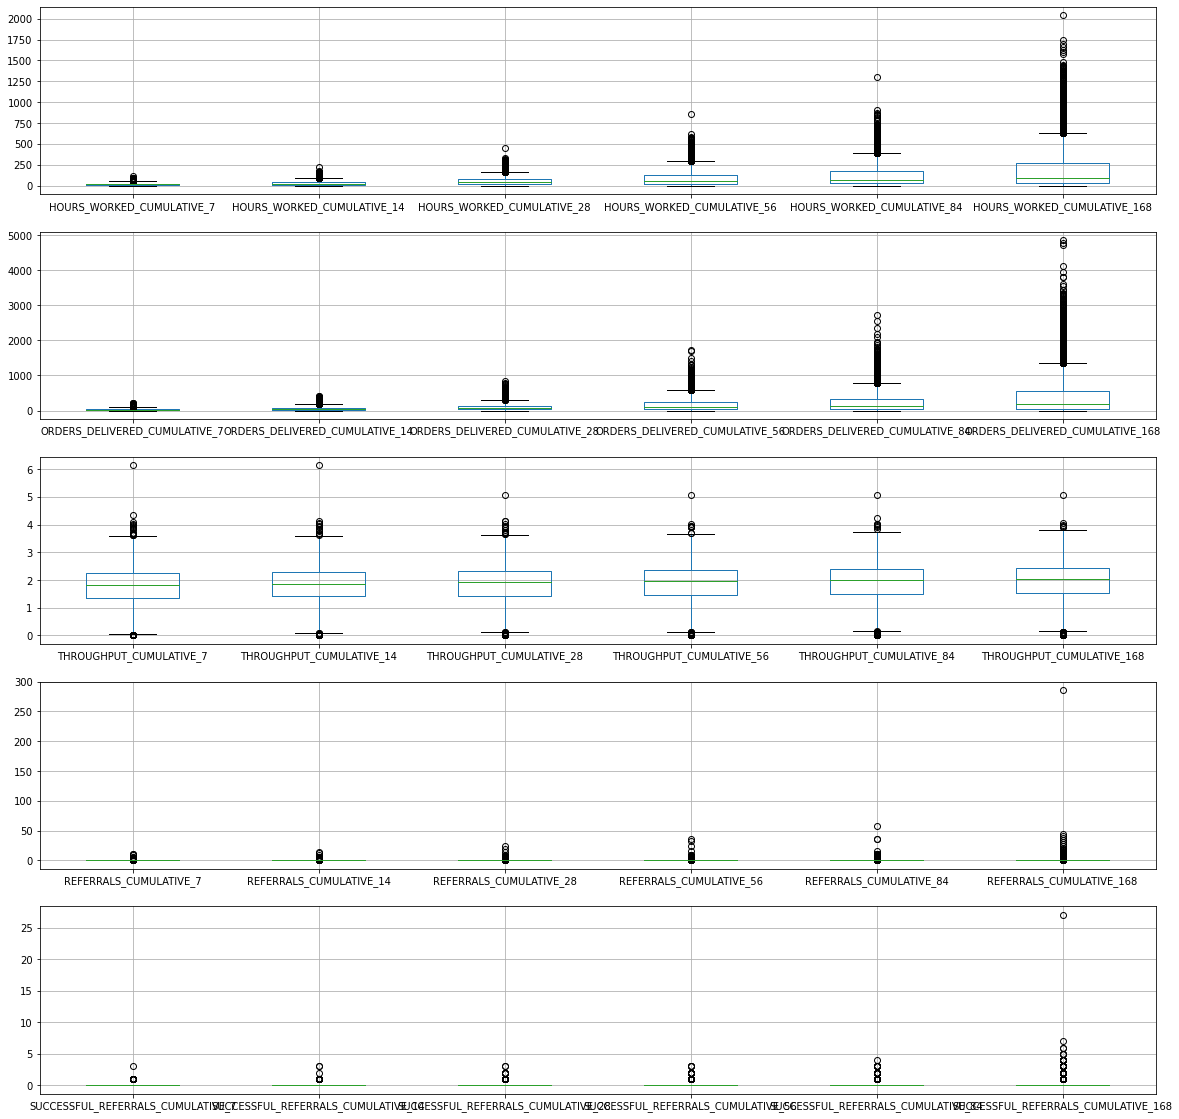

In [10]:
x = df_rolled.copy()
x = x[np.logical_or(x.VEHICLE_TYPE == 'Scooter / Motorcycle', x.VEHICLE_TYPE == 'Bicycle')]
_cols = ['HOURS_WORKED', 'ORDERS_DELIVERED', 'THROUGHPUT', 'REFERRALS', 'SUCCESSFUL_REFERRALS']
_, axs = plt.subplots(len(_cols), 1, figsize=(20, 20))
for _name, ax in zip(_cols, axs):
    x[[f'{_name}_CUMULATIVE_{d}' for d in days]].boxplot(ax=ax)

plt.show()

Take away points:
1. Throughput is a much more stable quantity than hours worked or orders delivered, it is much less effected by large outliers (since it's a somewhat normalized quantity). From now on we won't even really use the hours worked or orders delivered.
2. Throughput has some fairly large outliers. e.g. some few people averaging > 4 deliveries per hour. We should check the vehicle type here and maybe normalize by that somehow.
3. Some person made > 250 referalls in 168 days. There are also many people making many referrals. --> how many of these lead to success?
4. Outliers in the successful referalls.

#### Vehicle Type ####

From above we noticed some weird outliers in the throughput. This leads me to investigate the VEHICLE_TYPEs

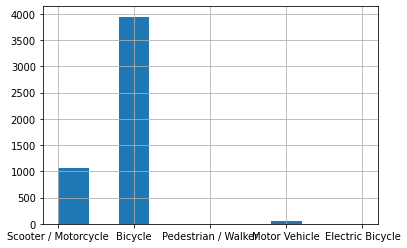

THROUGHPUT_CUMULATIVE_168                            \
                                         count      mean       std   min   
VEHICLE_TYPE                                                               
Bicycle                                 3946.0  1.891199  0.710110  0.00   
Electric Bicycle                           3.0  1.870000  0.668132  1.27   
Motor Vehicle                             44.0  2.057045  0.345318  1.42   
Pedestrian / Walker                        5.0  1.788000  0.900455  0.55   
Scooter / Motorcycle                    1067.0  2.183814  0.641022  0.00   

                                                
                        25%   50%    75%   max  
VEHICLE_TYPE                                    
Bicycle               1.460  1.98  2.390  5.07  
Electric Bicycle      1.510  1.75  2.170  2.59  
Motor Vehicle         1.815  2.08  2.305  2.75  
Pedestrian / Walker   1.670  1.81  1.820  3.09  
Scooter / Motorcycle  1.810  2.24  2.660  3.95

In [11]:
df_rolled['VEHICLE_TYPE'].hist()
plt.show()
plt.close()

df_rolled[['THROUGHPUT_CUMULATIVE_168', 'VEHICLE_TYPE']].groupby(["VEHICLE_TYPE"]).describe()

We can see that Electic Bicycle's & Walking make up ~= 0.1% of the vehicles, and have fairly different spreads, therefore we would like to remove these and keep only Bicycle's or Scooter/Motorcycle's. We check if these are correlated to `IS_RGR`

In [12]:
x = df_rolled.copy()
ct = pd.crosstab(index=x.VEHICLE_TYPE, columns=x.IS_RGR)
res = chi2, p, dof, ex = chi2_contingency(ct)
print(p)

1.6099332521559703e-83


Even though there is some correlation, intuition tells me that it's safe to drop those vehicle types, since they also don't appear in the referral rewards program here:
https://riders.deliveroo.co.uk/en/refer

In [13]:
df_rolled = df_rolled[~df_rolled.VEHICLE_TYPE.isin(['Electric Bicycle', 'Pedestrian / Walker'])]

#### Outliers in throughput ####

First we see one point that has avg throughput > 5, the next largest has ~ 4.

In [14]:
x = df_rolled.copy()
x = x[['RIDER_ID', 'VEHICLE_TYPE', *[x for x in df_rolled.columns if 'THROUGHPUT' in x]]]
x['AVG_CUMULATIVE_THROUGHPUT'] = x[[x for x in df_rolled.columns if 'THROUGHPUT' in x]].mean(axis=1)
x = x[x.AVG_CUMULATIVE_THROUGHPUT > np.sort(x.AVG_CUMULATIVE_THROUGHPUT)[::-1][4]]
x

,RIDER_ID,VEHICLE_TYPE,THROUGHPUT_CUMULATIVE_7,THROUGHPUT_CUMULATIVE_14,THROUGHPUT_CUMULATIVE_28,THROUGHPUT_CUMULATIVE_56,THROUGHPUT_CUMULATIVE_84,THROUGHPUT_CUMULATIVE_168,REFERRALS_THROUGHPUT_CUMULATIVE_7,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_7,...,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_14,REFERRALS_THROUGHPUT_CUMULATIVE_28,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_28,REFERRALS_THROUGHPUT_CUMULATIVE_56,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_56,REFERRALS_THROUGHPUT_CUMULATIVE_84,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_84,REFERRALS_THROUGHPUT_CUMULATIVE_168,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_168,AVG_CUMULATIVE_THROUGHPUT
13,33023,Bicycle,3.40,3.40,3.40,3.40,3.40,2.97,5.0,0.0,...,0.0,5.000000,0.0,5.000000,0.0,5.000000,0.0,0.845070,0.0,2.545282
896,69080,Bicycle,4.04,4.04,4.04,4.01,4.01,3.97,0.0,0.0,...,0.0,0.000000,0.0,0.833333,0.0,0.833333,0.0,0.769231,0.0,1.474772
2223,75733,Bicycle,6.15,6.15,5.07,5.07,5.07,5.07,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.810000
3278,82356,Bicycle,3.62,3.62,3.62,3.62,3.19,3.19,0.0,0.0,...,0.0,1.818182,0.0,1.818182,0.0,0.909091,0.0,0.909091,0.0,1.461919


We therefore drop that datapoint

In [15]:
df_rolled = df_rolled[df_rolled.THROUGHPUT_CUMULATIVE_168 < 5]

I also considered dropping data points that exist in the 90th percentile, but have made less than 5 deliveries.

In [16]:
df_rolled[np.logical_and(df_rolled.THROUGHPUT_CUMULATIVE_7 > df_rolled.THROUGHPUT_CUMULATIVE_168.quantile(0.90), df_rolled.ORDERS_DELIVERED_CUMULATIVE_168 < 5)]

,RIDER_ID,LOCATION,APPLICATION_DATE,APPLICATION_APPROVED_DATE,FIRST_WORK_DATE,IS_RGR,CHURNED_AFTER,ACQUISITION_CHANNEL,VEHICLE_TYPE,HOURS_WORKED_CUMULATIVE_7,...,REFERRALS_THROUGHPUT_CUMULATIVE_14,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_14,REFERRALS_THROUGHPUT_CUMULATIVE_28,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_28,REFERRALS_THROUGHPUT_CUMULATIVE_56,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_56,REFERRALS_THROUGHPUT_CUMULATIVE_84,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_84,REFERRALS_THROUGHPUT_CUMULATIVE_168,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_168
26,48280,Roo York,2016-08-04,2016-08-12,2016-10-26,False,7.0,Digital,Bicycle,1.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,0.0
3593,85566,Roo York,2016-05-29,2017-07-26,2016-12-27,False,7.0,Organic,Bicycle,1.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


#### Outliers in referrals ####

There's one person who's made more than 1 referall per day for 6 months. This outlier is so large that it can be removed

In [17]:
q = df_rolled[df_rolled.REFERRALS_CUMULATIVE_168 > 168].copy()
df_rolled = df_rolled[df_rolled.REFERRALS_CUMULATIVE_168 < 168]
q

,RIDER_ID,LOCATION,APPLICATION_DATE,APPLICATION_APPROVED_DATE,FIRST_WORK_DATE,IS_RGR,CHURNED_AFTER,ACQUISITION_CHANNEL,VEHICLE_TYPE,HOURS_WORKED_CUMULATIVE_7,...,REFERRALS_THROUGHPUT_CUMULATIVE_14,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_14,REFERRALS_THROUGHPUT_CUMULATIVE_28,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_28,REFERRALS_THROUGHPUT_CUMULATIVE_56,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_56,REFERRALS_THROUGHPUT_CUMULATIVE_84,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_84,REFERRALS_THROUGHPUT_CUMULATIVE_168,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_168
632,67787,Roo York,2016-09-16,2016-10-20,2016-10-23,False,NaN,Digital,Bicycle,8.9,...,0.145985,0.0,0.29661,0.0,0.591133,0.049261,1.032028,0.035587,2.757956,0.260366


In [67]:
x = df_rolled[df_rolled.IS_RGR].copy()
x = (x.APPLICATION_APPROVED_DATE - x.APPLICATION_DATE)
x[x >= pd.to_timedelta(1, unit='days')].sort_values()

3332     1 days
2040     1 days
4216     1 days
4773     1 days
1209     1 days
         ...   
4741   757 days
4716   766 days
4896   771 days
4889   772 days
3568   929 days
Length: 1198, dtype: timedelta64[ns]

In [68]:
df_rolled[df_rolled.index == 3332]

,RIDER_ID,LOCATION,APPLICATION_DATE,APPLICATION_APPROVED_DATE,FIRST_WORK_DATE,IS_RGR,CHURNED_AFTER,ACQUISITION_CHANNEL,VEHICLE_TYPE,HOURS_WORKED_CUMULATIVE_7,...,REFERRALS_THROUGHPUT_CUMULATIVE_14,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_14,REFERRALS_THROUGHPUT_CUMULATIVE_28,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_28,REFERRALS_THROUGHPUT_CUMULATIVE_56,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_56,REFERRALS_THROUGHPUT_CUMULATIVE_84,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_84,REFERRALS_THROUGHPUT_CUMULATIVE_168,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_168
3332,82962,Roo York,2016-12-15,2016-12-16,2016-12-16,True,NaN,Referral,Scooter / Motorcycle,24.8,...,0.027701,0.0,0.017668,0.0,0.011351,0.0,0.00885,0.0,0.005519,0.0


We collect some interesting plots first.

## Acuisition ##

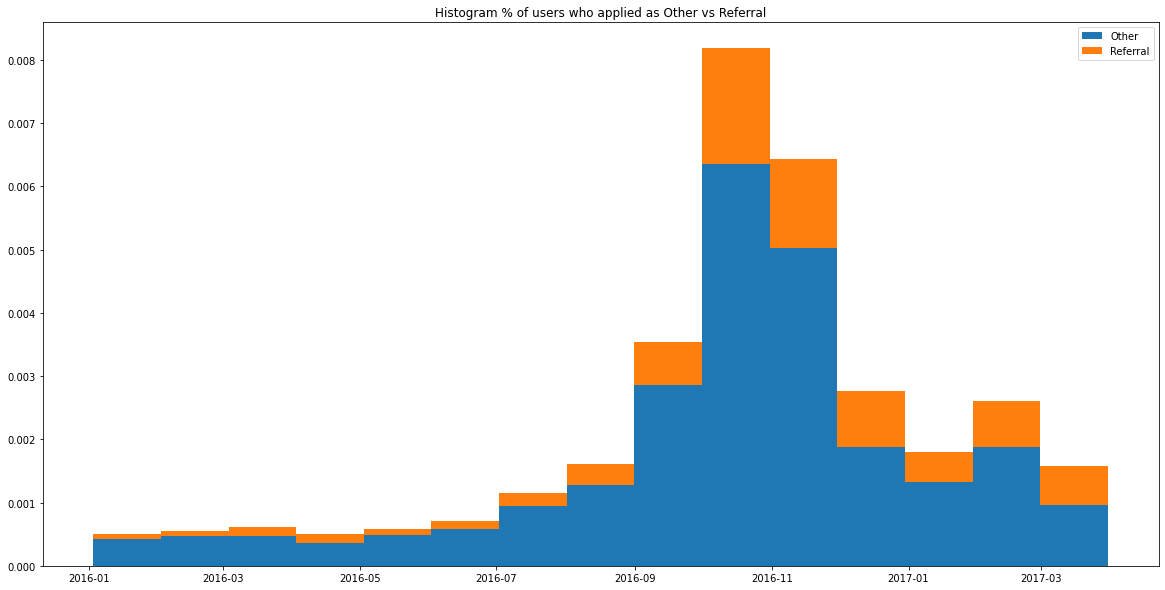

In [18]:
x = df_rolled.copy()
x = x[x.APPLICATION_DATE > '2016-01-01']
x.ACQUISITION_CHANNEL = x.ACQUISITION_CHANNEL.apply(lambda x: 'Referral' if x == 'Referral' else 'Other')
ad = x.pivot(columns='ACQUISITION_CHANNEL').APPLICATION_DATE
_ = plt.figure(figsize=(20, 10))
values, labels = zip(*[(ad[c].dropna(), c) for c in ad.columns])
plt.hist(
    values,
    stacked=True,
    bins=len(x.APPLICATION_DATE.dt.to_period('M').unique()),
    density=True,
    label=labels
)dam8unq

plt.title('Histogram % of users who applied as Other vs Referral')
plt.legend()
plt.show()
plt.close()

## Engagement ##

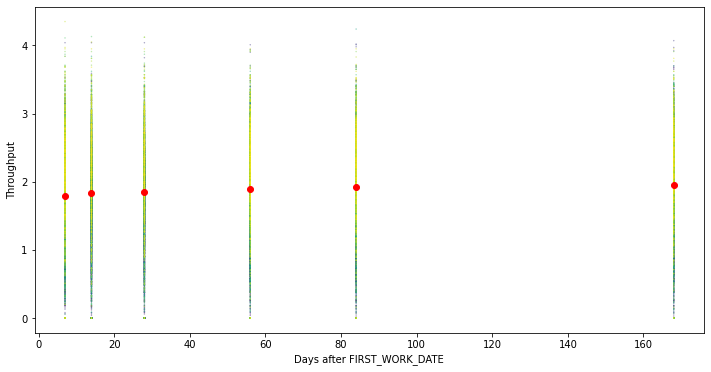

In [19]:
x = df_rolled.copy()

_ = plt.figure(figsize=(12, 6))
for day in days:
    plt.scatter([day for _ in range(len(x))], x[f'THROUGHPUT_CUMULATIVE_{day}'], c=list(range(len(x))), alpha=0.5, s=0.2)
    plt.scatter(day, x[f'THROUGHPUT_CUMULATIVE_{day}'].mean(), c='red')

plt.xlabel("Days after FIRST_WORK_DATE")
plt.ylabel("Throughput")
plt.show()
plt.close()

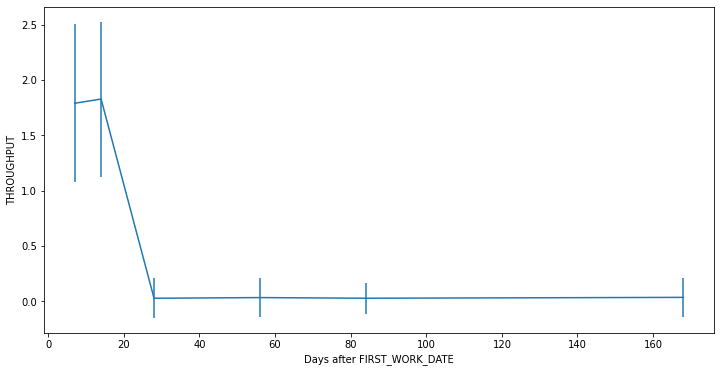

In [20]:
_df = df_rolled.copy()

_ = plt.figure(figsize=(12, 6))
y = []
y_err = []
x = []
for i in range(len(days)):
    worked = _df[f'THROUGHPUT_CUMULATIVE_{days[i]}']
    if i - 1 > 0:
        worked = worked - _df[f'THROUGHPUT_CUMULATIVE_{days[i-1]}']
    y.append(worked.mean())
    x.append(days[i])
    y_err.append(worked.std())

plt.errorbar(x, y, yerr=y_err)
plt.xlabel("Days after FIRST_WORK_DATE")
plt.ylabel("THROUGHPUT")
plt.show()
plt.close()

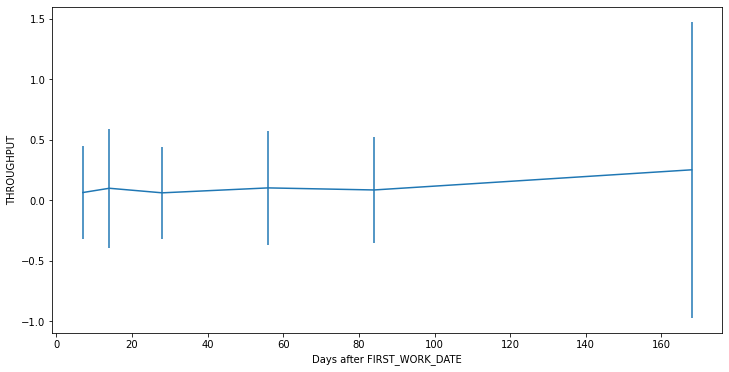

In [21]:
_df = df_rolled.copy()

_ = plt.figure(figsize=(12, 6))
y = []
y_err = []
x = []
for i in range(len(days)):
    worked = _df[f'REFERRALS_CUMULATIVE_{days[i]}']
    if i - 1 > 0:
        worked = worked - _df[f'REFERRALS_CUMULATIVE_{days[i-1]}']
    y.append(worked.mean())
    x.append(days[i])
    y_err.append(worked.std())

plt.errorbar(x, y, yerr=y_err)
plt.xlabel("Days after FIRST_WORK_DATE")
plt.ylabel("THROUGHPUT")
plt.show()
plt.close()

Referall paid out

In [22]:
def referral_fee(orders_made, vehicle, is_rgr):
    if not is_rgr:
        raise ValueError("Function only applies to referalls")

    if orders_made < 30:
        return np.nan
    
    if vehicle == 'Scooter / Motorcycle':
        return 100
    elif vehicle == 'Bicycle':
        return 100
    elif vehicle == 'Motor Vehicle':
        return 50
    raise ValueError(f"Unknown vehicle {vehicle}")
    

x = df_rolled[df_rolled.IS_RGR == True].copy()
y_paid = []
y_notpaid = []
for day in days:
    x[f'REFERRAL_FEE_PAID_{day}'] = x.apply(lambda q: referral_fee(q[f'ORDERS_DELIVERED_CUMULATIVE_{day}'], q['VEHICLE_TYPE'], q['IS_RGR']), axis=1)

x.REFERRAL_FEE_PAID_168.isna().sum(), len(x.REFERRAL_FEE_PAID_168)


(188, 1214)

In [23]:
# Higher % of RGR's in 95th percentile

df_rolled.groupby('IS_RGR').RIDER_ID.count() / len(df_rolled)


x = df_rolled[df_rolled.THROUGHPUT_CUMULATIVE_7 > df_rolled.THROUGHPUT_CUMULATIVE_7.quantile(0.95)]
x.groupby('IS_RGR').RIDER_ID.count() / len(x)

IS_RGR
False    0.698413
True     0.301587
Name: RIDER_ID, dtype: float64

#### Missing and inconsistent dates ####

In [24]:
print(f"Missing APPLICATION_DATE'S = {df_rolled.APPLICATION_DATE.isna().sum()}")
print(f"Missing APPLICATION_APPROVED_DATE'S = {df_rolled.APPLICATION_APPROVED_DATE.isna().sum()}")
x = np.logical_and(df_rolled.APPLICATION_APPROVED_DATE < df_rolled.APPLICATION_DATE, np.logical_and(~df_rolled.APPLICATION_DATE.isna(), ~df_rolled.APPLICATION_APPROVED_DATE.isna())).sum()
print(f"APPLICATION_APPROVED_DATE < APPLICATION_DATE = {x}")

x = np.logical_and(df_rolled.FIRST_WORK_DATE < df_rolled.APPLICATION_DATE, np.logical_and(~df_rolled.APPLICATION_DATE.isna(), ~df_rolled.FIRST_WORK_DATE.isna())).sum()
print(f"FIRST_WORK_DATE < APPLICATION_DATE = {x}")

x = np.logical_and(df_rolled.FIRST_WORK_DATE < df_rolled.APPLICATION_APPROVED_DATE, np.logical_and(~df_rolled.APPLICATION_APPROVED_DATE.isna(), ~df_rolled.FIRST_WORK_DATE.isna())).sum()
print(f"FIRST_WORK_DATE < APPLICATION_APPROVED_DATE = {x}")

Missing APPLICATION_DATE'S = 57
Missing APPLICATION_APPROVED_DATE'S = 50
APPLICATION_APPROVED_DATE < APPLICATION_DATE = 0
FIRST_WORK_DATE < APPLICATION_DATE = 0
FIRST_WORK_DATE < APPLICATION_APPROVED_DATE = 164


We would like, if possible, to drop the above. But, we should only drop them only if they are MCAR or MAR. To check that we perform Little's test.

Little's test proposes a null hypothesis H0: There is no association between the missing values and the target variable.

We use alpha = 0.05

In [364]:
"""Missing APPLICATION_DATE

H0: No association between the missingness of APPLICATION_DATE and IS_RGR.

"""
alpha = 0.05
x = df_rolled[['IS_RGR', 'RIDER_ID', 'APPLICATION_DATE']].drop_duplicates().copy()
x['APPLICATION_DATE_MISSING'] = x.APPLICATION_DATE.isna().astype(int)
table = x.groupby(['APPLICATION_DATE_MISSING', 'IS_RGR']).RIDER_ID.count().to_numpy().reshape((2,2))
chi2, p, dof, ex = chi2_contingency(table)
print(f"p-value={p}, reject H0={p<alpha}")

p-value= 0.031181749889049957, reject H0=True


In [365]:
"""Missing APPLICATION_APPROVED_DATE

H0: No association between the missingness of APPLICATION_APPROVED_DATE and IS_RGR.

"""
alpha = 0.05
x = df_rolled[['IS_RGR', 'RIDER_ID', 'APPLICATION_APPROVED_DATE']].drop_duplicates().copy()
x['APPLICATION_APPROVED_DATE_MISSING'] = x.APPLICATION_APPROVED_DATE.isna().astype(int)
table = x.groupby(['APPLICATION_APPROVED_DATE_MISSING', 'IS_RGR']).RIDER_ID.count().to_numpy().reshape((2,2))
chi2, p, dof, ex = chi2_contingency(table)
print(f"p-value={p}, reject H0={p<alpha}")

p-value= 0.05083292495295186, reject H0=False


In [368]:
"""Inconsistent FIRST_WORK_DATE

H0: There is no association between (APPLICATION_APPROVED_DATE < FIRST_WORK_DATE) and IS_RGR

"""
alpha = 0.05
x = df_rolled[['IS_RGR', 'RIDER_ID', 'APPLICATION_APPROVED_DATE', "FIRST_WORK_DATE"]].drop_duplicates().copy()
x = x[~x.APPLICATION_APPROVED_DATE.isna()]
x = x[~x.FIRST_WORK_DATE.isna()]
x['INCONSISTENT'] = (x.FIRST_WORK_DATE < x.APPLICATION_APPROVED_DATE).astype(int)
table = x.groupby(['INCONSISTENT', 'IS_RGR']).RIDER_ID.count().to_numpy().reshape((2,2))
chi2, p, dof, ex = chi2_contingency(table)
print(f"p-value={p}, reject H0={p<alpha}")

p-value=0.07758520905899503, reject H0=False


In [370]:
df[df.APPLICATION_APPROVED_DATE.isna()].groupby(["IS_RGR"]).RIDER_ID.count() / df.groupby(["IS_RGR"]).RIDER_ID.count()

IS_RGR
False    0.011951
True     0.004934
Name: RIDER_ID, dtype: float64

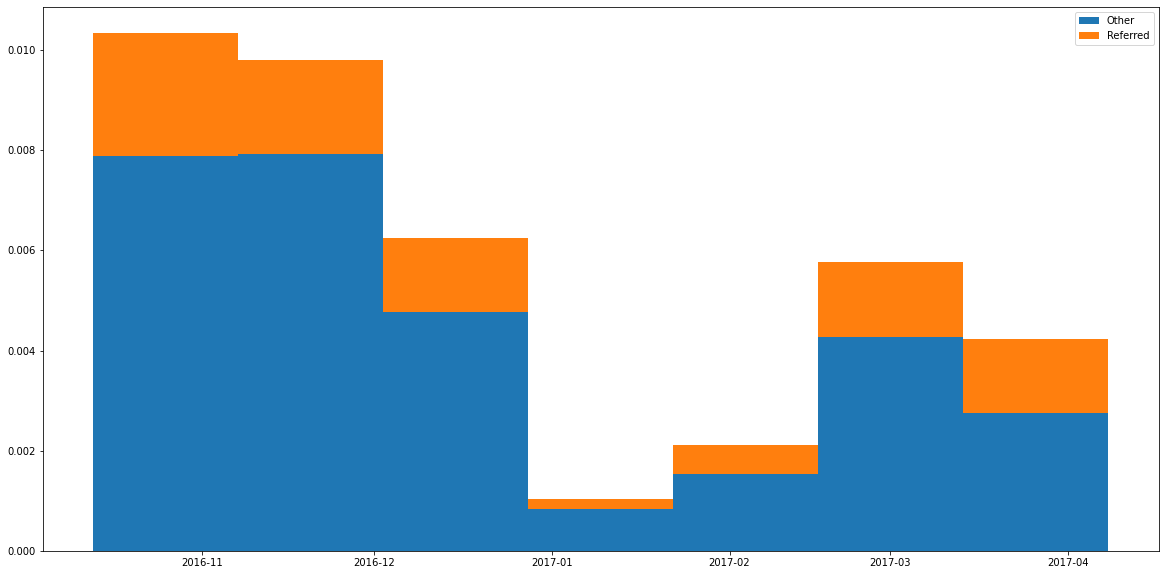

In [259]:
_df = df_rolled.copy()
ad = _df.pivot(columns='IS_RGR').FIRST_WORK_DATE
_ = plt.figure(figsize=(20, 10))
plt.hist([ad[False].dropna(), ad[True].dropna()], stacked=True, bins=len(_df.FIRST_WORK_DATE.dt.to_period('M').unique()), density=True, label=['Other', 'Referred'])
plt.legend()
plt.show()
plt.close()

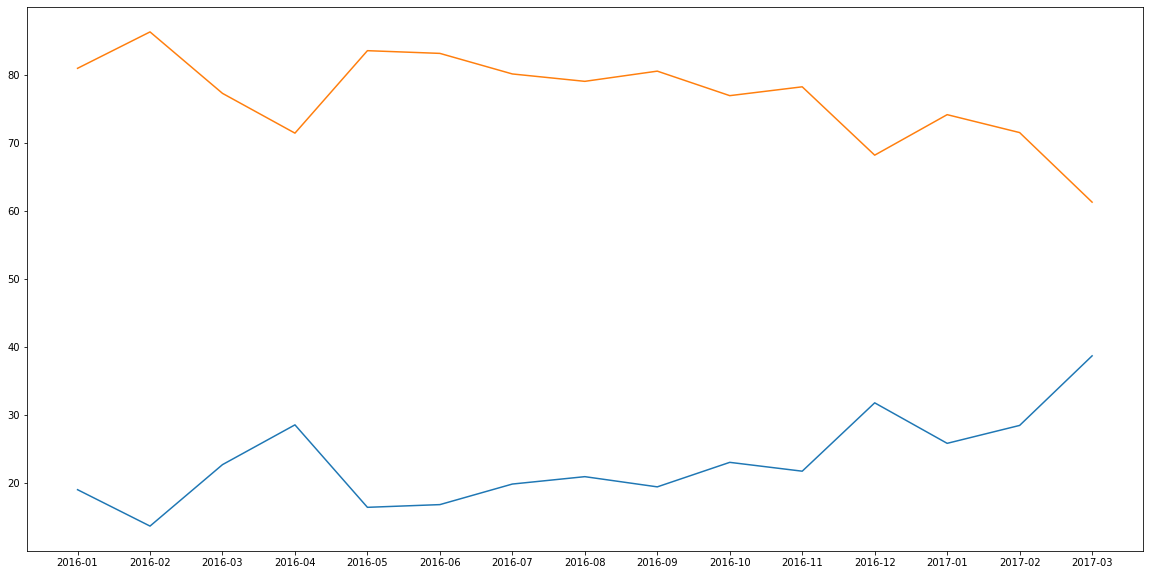

In [291]:
_df = df_rolled.copy()
_df = _df[_df.APPLICATION_DATE > '2016-01-01']  # we only consider 2016, since there are not that many data points in 2015
_df.APPLICATION_DATE = _df.APPLICATION_DATE.dt.to_period('M')
app_dates = np.sort(_df.APPLICATION_DATE.unique().dropna())
referrals, other = {}, {}
for date in app_dates:
    referrals[str(date)] = _df[np.logical_and(_df.APPLICATION_DATE == date, _df.IS_RGR)].RIDER_ID.count()
    other[str(date)] = _df[np.logical_and(_df.APPLICATION_DATE == date, ~_df.IS_RGR)].RIDER_ID.count()

p = {d: 100 * referrals[d] / (referrals[d] + other[d]) for d in referrals}
_ = plt.figure(figsize=(20, 10))
plt.plot(p.keys(), p.values())
p = {d: 100 * other[d] / (referrals[d] + other[d]) for d in referrals}
plt.plot(p.keys(), p.values())
plt.show()
plt.close()


In [6]:
df_rolled[np.logical_and(df_rolled.REFERRALS_CUMULATIVE_168 > 1, df_rolled.ORDERS_DELIVERED_CUMULATIVE_168 >= 30)][['SUCCESSFUL_REFERRALS_CUMULATIVE_168', 'REFERRALS_CUMULATIVE_168']]

In [41]:
df_rolled.groupby('IS_RGR').CHURNED.mean()

IS_RGR
False    0.470557
True     0.426644
Name: CHURNED, dtype: float64

In [42]:
_df = df_rolled[df_rolled.CHURNED_AFTER < 15]
_df.groupby('IS_RGR').RIDER_ID.count()

IS_RGR
False    639
True     149
Name: RIDER_ID, dtype: int64

In [43]:
_df = df_rolled[~df_rolled.IS_RGR]
(_df.FIRST_WORK_DATE - _df.APPLICATION_DATE).describe()

count                           3667
mean      87 days 10:38:07.428415599
std      128 days 14:37:10.352650292
min                  0 days 00:00:00
25%                 14 days 00:00:00
50%                 30 days 00:00:00
75%                 99 days 00:00:00
max                740 days 00:00:00
dtype: object

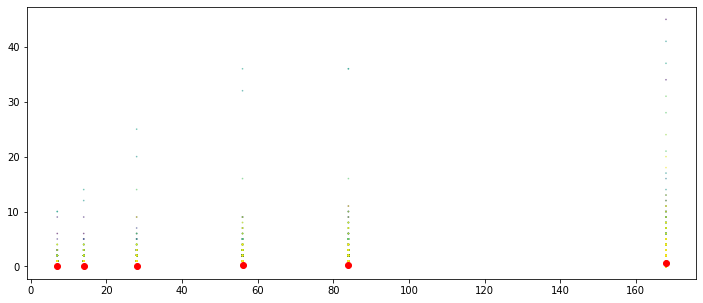

In [51]:
_ = plt.figure(figsize=(12, 5))
_df = df_rolled.copy()
for day in days:
    plt.scatter([day for _ in range(len(_df))], _df[f'REFERRALS_CUMULATIVE_{day}'], c=list(range(len(_df))), alpha=0.5, s=0.5)
    plt.scatter(day, _df[f'REFERRALS_CUMULATIVE_{day}'].mean(), c='red')

plt.show()
plt.close()

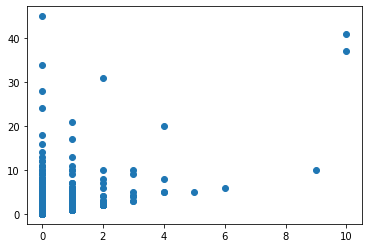

In [57]:
plt.scatter(df_rolled.REFERRALS_CUMULATIVE_7, df_rolled.REFERRALS_CUMULATIVE_168)

In [54]:
df_rolled[np.logical_and(df_rolled.REFERRALS_CUMULATIVE_7 < 1, df_rolled.REFERRALS_CUMULATIVE_28 > 1)]

,RIDER_ID,LOCATION,APPLICATION_DATE,APPLICATION_APPROVED_DATE,FIRST_WORK_DATE,IS_RGR,CHURNED_AFTER,ACQUISITION_CHANNEL,VEHICLE_TYPE,HOURS_WORKED_CUMULATIVE_7,...,REFERRALS_THROUGHPUT_CUMULATIVE_14,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_14,REFERRALS_THROUGHPUT_CUMULATIVE_28,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_28,REFERRALS_THROUGHPUT_CUMULATIVE_56,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_56,REFERRALS_THROUGHPUT_CUMULATIVE_84,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_84,REFERRALS_THROUGHPUT_CUMULATIVE_168,SUCCESSFUL_REFERRALS_THROUGHPUT_CUMULATIVE_168
38,54866,Roo York,2016-08-14,2016-08-29,2016-11-15,False,NaN,Offline,Bicycle,12.3,...,0.039216,0.000000,0.034014,0.000000,0.026978,0.008993,0.026978,0.008993,0.020419,0.005105
240,65974,Roo York,2016-10-04,2016-10-10,2016-10-16,False,28.0,Organic,Scooter / Motorcycle,25.2,...,0.000000,0.000000,0.027701,0.000000,0.027701,0.000000,0.027701,0.000000,0.027701,0.000000
334,66565,Roo York,2015-09-25,2016-10-14,2016-10-14,False,84.0,Organic,Bicycle,0.7,...,0.357143,0.178571,0.188679,0.188679,0.082645,0.082645,0.051680,0.051680,0.051680,0.051680
412,67016,Roo York,2016-05-18,2016-10-16,2016-10-19,False,28.0,Digital,Bicycle,12.4,...,0.159574,0.000000,0.102389,0.000000,0.102389,0.000000,0.102389,0.000000,0.102389,0.000000
660,67917,Roo de Janeiro,2016-10-08,2016-10-21,2016-10-22,False,NaN,Organic,Bicycle,42.3,...,0.061576,0.000000,0.031666,0.000000,0.019592,0.000000,0.011710,0.000000,0.008832,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4924,101711,Roo York,2017-03-06,2017-03-20,2017-03-20,True,NaN,Referral,Scooter / Motorcycle,27.5,...,0.048662,0.000000,0.049100,0.016367,0.041899,0.013966,0.039630,0.013210,0.049751,0.012438
5026,102338,Roo York,2017-01-24,2017-03-25,2017-03-25,False,NaN,Organic,Scooter / Motorcycle,50.9,...,0.000000,0.000000,0.017167,0.000000,0.008692,0.004346,0.009479,0.006319,0.004906,0.003679
5071,102552,Roo York,2016-10-15,2017-03-26,2017-03-27,False,NaN,Organic,Scooter / Motorcycle,40.2,...,0.000000,0.000000,0.032751,0.000000,0.038797,0.009699,0.035587,0.008897,0.028633,0.007158
5077,102579,Roo York,2017-03-25,2017-03-26,2017-03-28,False,84.0,Organic,Bicycle,19.3,...,0.000000,0.000000,0.037523,0.000000,0.022573,0.000000,0.018622,0.000000,0.018622,0.000000


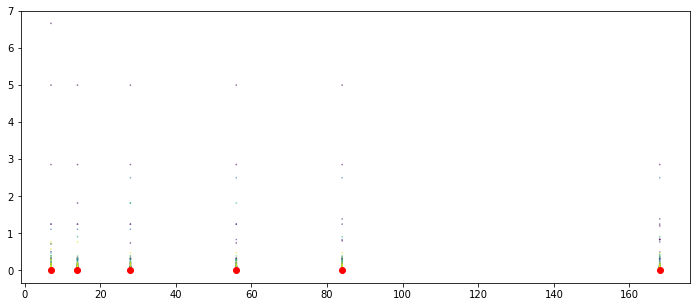

In [52]:
_ = plt.figure(figsize=(12, 5))
_df = df_rolled.copy()
for day in days:
    plt.scatter([day for _ in range(len(_df))], _df[f'REFERRALS_THROUGHPUT_CUMULATIVE_{day}'], c=list(range(len(_df))), alpha=0.5, s=0.5)
    plt.scatter(day, _df[f'REFERRALS_THROUGHPUT_CUMULATIVE_{day}'].mean(), c='red')

plt.show()
plt.close()

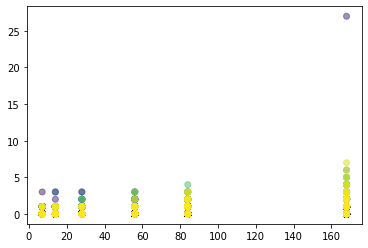

In [48]:
_df = df_rolled  # .sample(20)
for day in days:
    plt.scatter([day for _ in range(len(_df))], _df[f'SUCCESSFUL_REFERRALS_CUMULATIVE_{day}'], c=list(range(len(_df))), alpha=0.5)

plt.show()
plt.close()

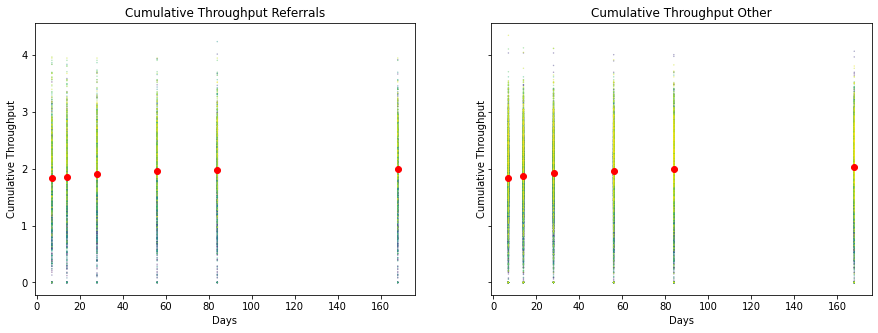

In [36]:
_df = df_rolled  # .sample(20)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
_df_r = _df[_df.IS_RGR]
_df_n = _df[~_df.IS_RGR]
for day in days:
    ax1.scatter([day for _ in range(len(_df_r))], _df_r[f'THROUGHPUT_CUMULATIVE_{day}'], c=list(range(len(_df_r))), alpha=0.5, s=0.2)
    ax1.scatter(day, _df_r[f'THROUGHPUT_CUMULATIVE_{day}'].median(), c='red')
    ax2.scatter([day for _ in range(len(_df_n))], _df_n[f'THROUGHPUT_CUMULATIVE_{day}'], c=list(range(len(_df_n))), alpha=0.5, s=0.2)
    ax2.scatter(day, _df_n[f'THROUGHPUT_CUMULATIVE_{day}'].median(), c='red')

ax1.set_title("Cumulative Throughput Referrals")
ax2.set_title("Cumulative Throughput Other")
ax1.set_ylabel("Cumulative Throughput")
ax2.set_ylabel("Cumulative Throughput")
ax1.set_xlabel("Days")
ax2.set_xlabel("Days")

plt.show()
plt.close()

In [51]:
df_rolled[np.logical_and(df_rolled.REFERRALS_CUMULATIVE_168 > 1, df_rolled.ORDERS_DELIVERED_CUMULATIVE_168 < 30)][['SUCCESSFUL_REFERRALS_CUMULATIVE_168', 'REFERRALS_CUMULATIVE_168']]
df_rolled[np.logical_and(df_rolled.REFERRALS_CUMULATIVE_168 > 1, df_rolled.ORDERS_DELIVERED_CUMULATIVE_168 >= 30)][['SUCCESSFUL_REFERRALS_CUMULATIVE_168', 'REFERRALS_CUMULATIVE_168']]

2042.4

#### Estimaiting profit made ####

We compute profit made, if every delivery is worth the average price. According to the following article: https://www.thegrocer.co.uk/fundraising/deliveroo-is-it-really-worth-88bn/654624.article the average order value is around £20, and Deliveroo makes £2.07 gross profit per order, HSBC Global Research calculates, though it is difficult to be precise. I am assuming that this value has not already been adjusted for the referral fees.

0.875 0.125


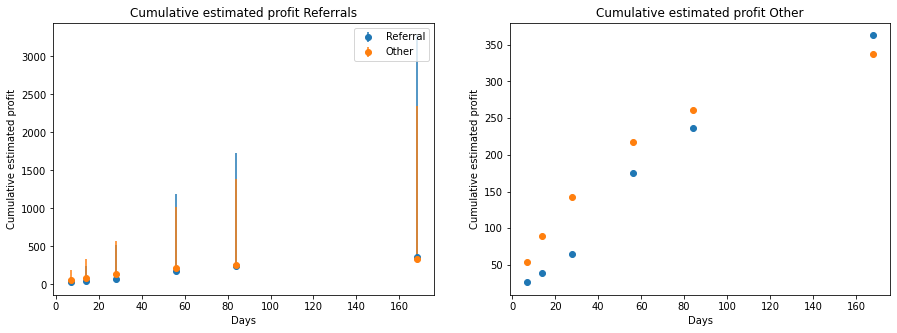

In [35]:
def referral_fee(orders_made, vehicle, is_rgr):
    if not is_rgr or orders_made < 30:
        return 0
    
    if vehicle == 'Scooter / Motorcycle':
        return 100
    elif vehicle == 'Bicycle':
        return 100
    elif vehicle == 'Motor Vehicle':
        return 50
    raise ValueError(f"Unknown vehicle {vehicle}")
    

def profit_made(orders_made: int, vehicle: str, is_rgr: bool, average_delivery_profit: float = 2.07):
    fee = referral_fee(orders_made, vehicle, is_rgr=is_rgr)
    profit = average_delivery_profit * orders_made - fee
    return profit
    
x = df_rolled.copy()
for day in days:
    x[f'ESTIMATED_PROFIT_CUMULATIVE_{day}'] = x.apply(lambda q: profit_made(q[f'ORDERS_DELIVERED_CUMULATIVE_{day}'], q['VEHICLE_TYPE'], q['IS_RGR']), axis=1)

x = x[['RIDER_ID', 'IS_RGR', *[f'ESTIMATED_PROFIT_CUMULATIVE_{day}' for day in days]]]


_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
_df_r = x[_df.IS_RGR]
_df_n = x[~_df.IS_RGR]
y1, y2, y1errup, y1errdown, y2errup, y2errdown = [], [], [], [], [], []
quantile = 0.75
quantile_up = (1 + quantile) / 2
quantile_down = (1 - quantile) / 2
for day in days:
    # ax1.scatter([day for _ in range(len(_df_r))], _df_r[f'ESTIMATED_PROFIT_CUMULATIVE_{day}'], c=list(range(len(_df_r))), alpha=0.5, s=0.2)
    # ax1.scatter(day, _df_r[f'ESTIMATED_PROFIT_CUMULATIVE_{day}'].mean(), c='red')
    # ax2.scatter([day for _ in range(len(_df_n))], _df_n[f'ESTIMATED_PROFIT_CUMULATIVE_{day}'], c=list(range(len(_df_n))), alpha=0.5, s=0.2)
    # ax2.scatter(day, _df_n[f'ESTIMATED_PROFIT_CUMULATIVE_{day}'].mean(), c='red')
    
    # ax1.scatter(day, _df_r[f'ESTIMATED_PROFIT_CUMULATIVE_{day}'].mean(), c='red')
    # ax1.scatter(day, _df_n[f'ESTIMATED_PROFIT_CUMULATIVE_{day}'].mean(), c='blue')
    y1.append(_df_r[f'ESTIMATED_PROFIT_CUMULATIVE_{day}'].median())
    y1errup.append(_df_r[f'ESTIMATED_PROFIT_CUMULATIVE_{day}'].quantile(quantile_up))
    y1errdown.append(_df_r[f'ESTIMATED_PROFIT_CUMULATIVE_{day}'].quantile(quantile_down))
    
    y2.append(_df_n[f'ESTIMATED_PROFIT_CUMULATIVE_{day}'].median())
    y2errup.append(_df_n[f'ESTIMATED_PROFIT_CUMULATIVE_{day}'].quantile(quantile_up))
    y2errdown.append(_df_n[f'ESTIMATED_PROFIT_CUMULATIVE_{day}'].quantile(quantile_down))
    

print(quantile_up, quantile_down)
ax1.errorbar(days, y1, yerr=(y1errdown, y1errup), label='Referral', fmt="o")
ax1.errorbar(days, y2, yerr=(y2errdown, y2errup), label='Other', fmt="o")
ax2.scatter(days, y1, label='Referral')
ax2.scatter(days, y2, label='Other')
ax1.set_title("Cumulative estimated profit Referrals")
ax2.set_title("Cumulative estimated profit Other")
ax1.set_ylabel("Cumulative estimated profit")
ax2.set_ylabel("Cumulative estimated profit")
ax1.set_xlabel("Days")
ax2.set_xlabel("Days")
ax1.legend()

plt.show()
plt.close()

In [33]:
_df_n.ESTIMATED_PROFIT_CUMULATIVE_168.median()

337.40999999999997

In [34]:
_df_r.ESTIMATED_PROFIT_CUMULATIVE_168.median()

362.645